# Style Transfer with PyTorch 🖼️

<p style="font-size:16px">
Style Transfer involves copying the style of one image (the Style Image) and applying it to another image (the Content Image). The outcome is a new image (the Target Image) that combines the content of the Content Image with the style of the Style Image.<p>

<p style="font-size:18px"><b>Implementation Overview</b></p>
<ol style="font-size:16px">
    <li>Import Libraries</li>
    <li>Load Images Paths</li>
    <li>Preprocessing the Images</li>
    <li>Define the Pretrained Model</li>
    <li>Style Transfer Loop</li>
</ol>


# Libraries

In [1]:
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd

import torch as T
import torch.nn.functional as F
import torch.optim as optim
from torchvision import models
from torchvision import transforms
from torch.utils.data import DataLoader, Dataset

In [2]:
# GPU
device = T.device("cuda" if T.cuda.is_available() else "cpu")

# Loading Image Paths into a DataFrame

## Loading Monet Images

In [3]:
monet_df = []
for root,_, files in os.walk('/kaggle/input/gan-getting-started/monet_jpg'):
    for filename in files:
        path = os.path.join(root+'/'+filename)
        monet_df.append(path)

monet_df = pd.DataFrame(monet_df, columns=['filename'])

In [4]:
print(f"Number of Monet Images: {monet_df.shape[0]}")

Number of Monet Images: 300


## Loading Content Images

In [5]:
photo_df = []
for root,_, files in os.walk('/kaggle/input/gan-getting-started/photo_jpg'):
    for filename in files:
        path = os.path.join(root+'/'+filename)        
        photo_df.append(path)

photo_df = pd.DataFrame(photo_df, columns=['filename'])

In [6]:
print(f"Number of Content Images: {photo_df.shape[0]}")

Number of Content Images: 7038


In [7]:
# Sampling the content image dataframe
photo_df = photo_df.sample(5)

# Transformations

<p style="font-size:16px"><p style="font-size:16px">The CNN requires images to be normalized and converted into tensor format</p>

In [8]:
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

In [9]:
transformations = transforms.Compose([
    transforms.Resize((256,256)), # Resize to a (256,256) image
    transforms.ToTensor(),        # Convert to a Tensor
    transforms.Normalize(mean, std) # Normalize
])

# Pretrained model

In [10]:
# Loading pretrained model
vgg = models.vgg19(pretrained=True).features

# Freeze layers
for params in vgg.parameters():
    params.requires_grad_(False)
    
vgg.to(device)

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth
100%|██████████| 548M/548M [00:03<00:00, 185MB/s] 


Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (17): ReLU(inplace=True)
  (18): MaxPoo

<p style="font-size:18px"><b>Feature Maps and Layers</b></p>

<p style="font-size:16px">In convolutional neural networks, earlier layers capture fine details, while higher layers capture more abstract features. When processing an image, each layer produces a feature map, which is a representation of the input image containing spatial and structural information. To use these feature maps for style transfer, we can extract features from specific layers and perform further processing to obtain the style information.</p>

<p style="font-size:18px"><b>Gram Matrix</b></p>

<p style="font-size:16px">To capture the style from the Style Image, we utilize the Gram matrix of the feature maps. The Gram matrix signifies the correlations among different channels in the feature map, encoding style information while discarding spatial details.</p>

# Preprocessing

In [11]:
class Preprocessing():
    
    def __init__(self, weights, layers):
        # layer importance
        self.weights = weights
        # layer of interest
        self.layers_of_interest = layers
        
    def apply_model_and_extract_features(self,image, model):
        
        x = image
        
        features = {}
        
        for name, layer in model._modules.items():
            # Passing the image into the pretrained model
            x = layer(x)
            # Extract features from layers of interest
            if name in LAYERS_OF_INTEREST:
                features[LAYERS_OF_INTEREST[name]] = x

        return features
        
    def calculate_gram_matrix(self,tensor_image):
        """
            Compute the Gram Matrix 
            
        """
        _, channels, height, width = tensor_image.size()

        tensor_image = tensor_image.view(channels, height*width)

        gram_matrix = T.mm(tensor_image, tensor_image.t())

        gram_matrix = gram_matrix.div(channels * height * width)

        return gram_matrix
    
    def tensor_to_image(self,image_tensor):
        """
            Convert a Tensor Image to an Image
        """
        image = image_tensor.clone().detach()
        image = image.cpu().numpy().squeeze()
        
        # Transpose (C, W, H) -> (W, H, C)
        image = image.transpose(1,2,0)
        # Desnormalize
        image *= np.array(std) + np.array(mean)
        # Convert to 0-255 scale
        image[:,:,0] = image[:,:,0] * 255
        image[:,:,1] = image[:,:,1] * 255
        image[:,:,2] = image[:,:,2] * 255
        image = np.clip(image, 0, 255).astype(np.uint8)
        
        return image
    
    

# Perform Style Transfer

<p style="font-size:18px"><b>Content Extraction</b></p>
<p style="font-size:16px">To extract content information from the content image, we utilize the convolutional layer 'conv4_2'. This layer captures intermediate-level features that strike a balance between fine details and abstract representations.</p>

<p style="font-size:18px"><b>Style Extraction</b></p>
<p style="font-size:16px">To extract style features, we compute Gram matrices from several layers of interest ('conv1_1', 'conv2_1', 'conv3_1', 'conv4_1', and 'conv5_1'). These layers capture varying levels of style information, ranging from fine details to abstract patterns.</p>

<p style="font-size:18px"><b>Layer Importance</b></p>

<p style="font-size:16px">The weights assigned to each style layer determine the significance of the style information extracted from that layer, with earlier layers usually receiving higher weights to highlight finer details.</p>

In [12]:
# Layer importance
weights = {'conv1_1': 1.0, 'conv2_1': 0.75, 'conv3_1': 0.35,
          'conv4_1': 0.25, 'conv5_1': 0.15}

# Layer of interest
LAYERS_OF_INTEREST = {
    '0': 'conv1_1',
    '5': 'conv2_1',
    '10': 'conv3_1',
    '19': 'conv4_1',
    '21': 'conv4_2',
    '28': 'conv5_1'    
}

preprocessing = Preprocessing(weights, LAYERS_OF_INTEREST)

In [13]:
# Output directory of the final images
output_dir = "/kaggle/working/images/"
monet_idx_list = []

for i, img_path in enumerate(photo_df.iloc[:,0]):
    
    print(f"Image number: {i+1}")
    # Load the image
    img = Image.open(img_path)        
    # Apply transformations
    content_image = transformations(img).to(device)
    content_image = content_image.unsqueeze(0)
    
    # Select a random index  
    monet_idx = np.random.randint(0,300, size=1)
    monet_idx_list.append(monet_idx)
    # Load the monet image
    monet_img = Image.open(monet_df.iloc[monet_idx[0],0])
    # Apply transformations
    style_image = transformations(monet_img).to(device)
    style_image = style_image.unsqueeze(0)
    
    # Copy the content of content image into the final image (target)
    target = content_image.clone().requires_grad_(True).to(device)
    
    # Optimizer
    optimizer = optim.Adam([target], lr=0.003)
    
    # Loop of performing style transfer
    for iteration in range(1, 1500):       
        # Extracting features from content image, style image, and final image
        content_img_features = preprocessing.apply_model_and_extract_features(content_image, vgg)
        style_img_features = preprocessing.apply_model_and_extract_features(style_image, vgg)        
        target_features = preprocessing.apply_model_and_extract_features(target, vgg)
        
        # Compute the content loss
        content_loss = F.mse_loss(target_features["conv4_2"], content_img_features["conv4_2"])

        style_loss = 0
        # Calculate the Gram Matrices of style image
        style_features_gram_matrix = {layer: preprocessing.calculate_gram_matrix(style_img_features[layer]) for layer in style_img_features}

        for layer in weights:
            
            target_feature = target_features[layer]
            # Calculate the Gram Matrix of final image
            target_gram_matrix = preprocessing.calculate_gram_matrix(target_feature)
            style_gram_matrix = style_features_gram_matrix[layer]
            
            # Compute the layer loss
            layer_loss = F.mse_loss(target_gram_matrix, style_gram_matrix)
            # Compute weighted layer loss
            layer_loss *= weights[layer]

            _, channels, height, width = target_feature.shape
            # Add the layer loss to style loss
            style_loss += layer_loss
        
        # Compute total loss
        total_loss = 1000000 * style_loss + content_loss

        optimizer.zero_grad()

        total_loss.backward()

        optimizer.step()
    
    # Convert final image to an array
    target_img = preprocessing.tensor_to_image(target)
    
    # Save the final image
    target_img = Image.fromarray(target_img)
    
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
    target_img.save("/kaggle/working/images/" + str(i) + ".jpg")       
    

Image number: 1
Image number: 2
Image number: 3
Image number: 4
Image number: 5


# Display Final Results

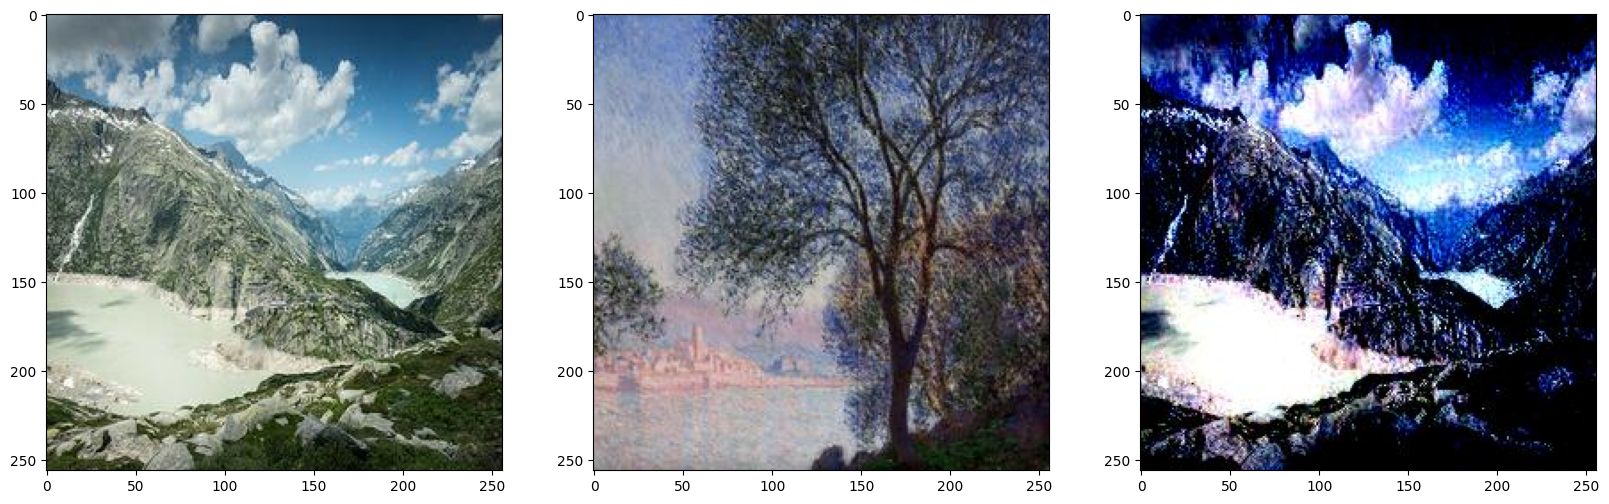

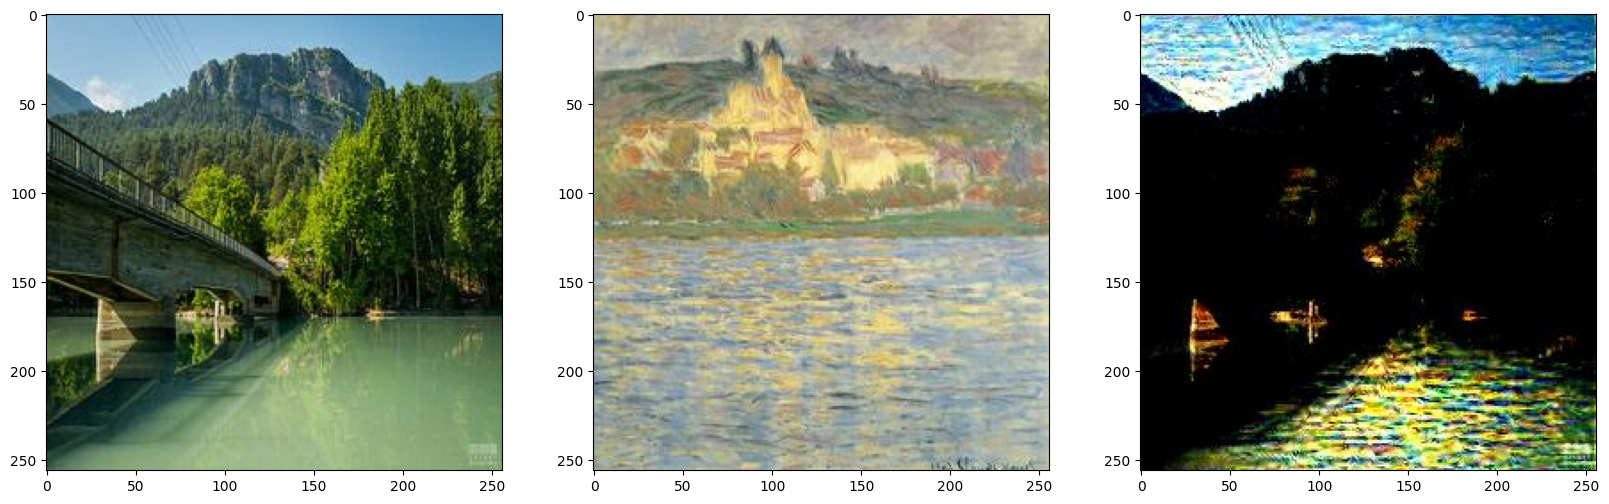

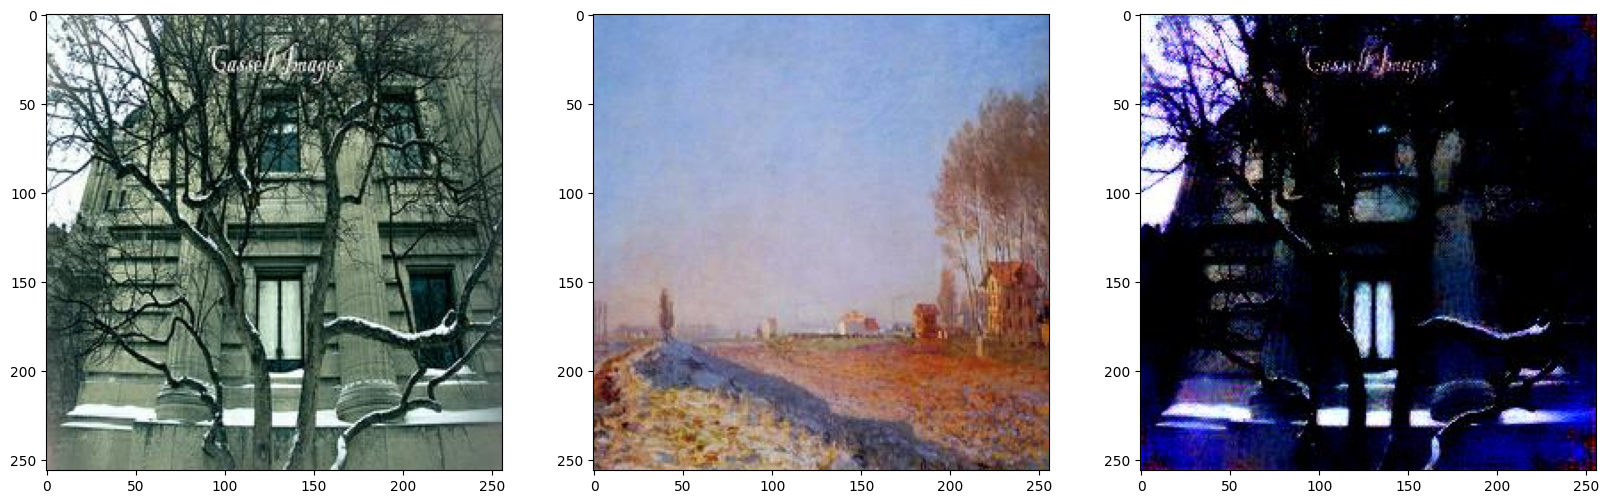

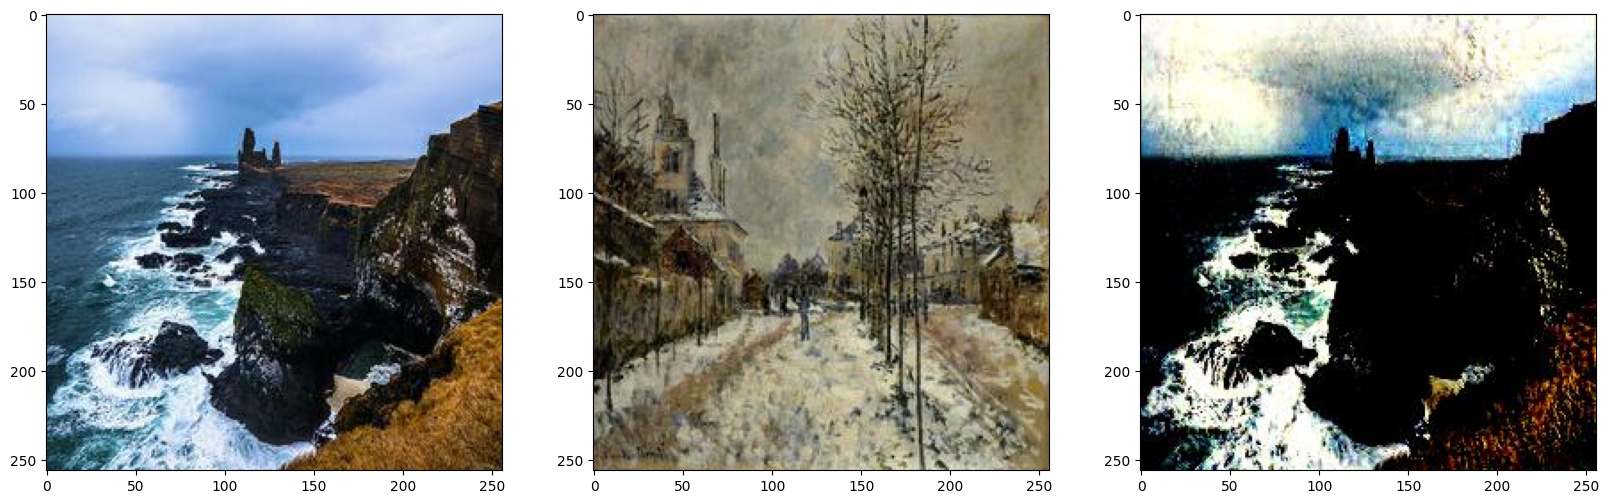

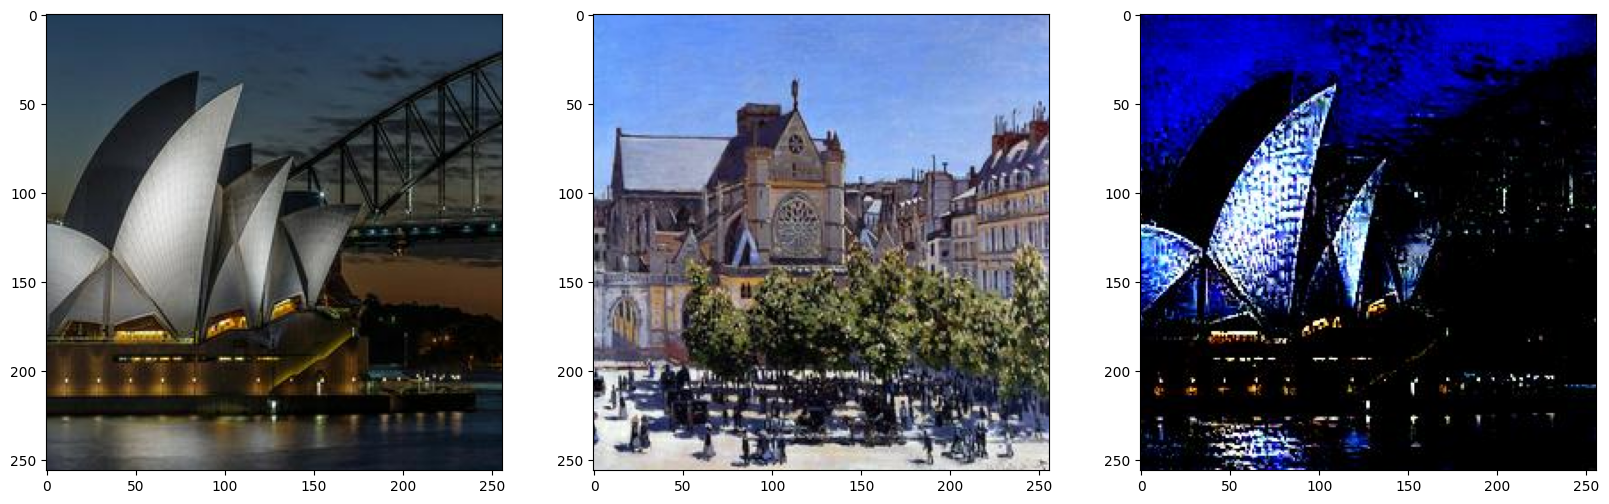

In [14]:
for i, content_path in zip(range(5), photo_df.iloc[:,0]):
    fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(20,10))
    
    content_image = Image.open(content_path) 
    monet_image = Image.open(monet_df.iloc[monet_idx_list[i][0],0])
    final_image = Image.open(f"/kaggle/working/images/{i}.jpg")
    ax1.imshow(content_image)
    ax2.imshow(monet_image)
    ax3.imshow(final_image)